In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras as keras
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Activation, Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape, Concatenate, concatenate

### 数据处理

In [30]:
# 读取数据
data_ini = pd.read_excel('data/TJ POLTS.xlsx')

data = data_ini.iloc[:,[1,3,4,5,6,7,8]]
data.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,310,260,420,139,201,3.5,13
1,225,175,271,111,143,3.2,31
2,275,225,360,128,197,3.9,12
3,126,96,183,70,101,2.3,26
4,116,88,159,70,114,1.6,16


In [31]:
# 指数平滑
def expPreprocessing(df, alpha=0.05):
    edata = df.ewm(alpha=alpha, adjust=False).mean()
    return edata

alpha = 0.05
data_exp = expPreprocessing(data, alpha)
data_exp.head()

# alpha = 0.05
# data_exp = data.ewm(alpha=alpha, adjust=False).mean()
# data_exp.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,310.000000,260.000000,420.000000,139.0000,201.000000,3.500000,13.000000
1,305.750000,255.750000,412.550000,137.6000,198.100000,3.485000,13.900000
2,304.212500,254.212500,409.922500,137.1200,198.045000,3.505750,13.805000
3,295.301875,246.301875,398.576375,133.7640,193.192750,3.445462,14.414750
4,286.336781,238.386781,386.597556,130.5758,189.233112,3.353189,14.494013


In [32]:
# 归一化
min_value = data_exp.min(axis=0)  
max_value = data_exp.max(axis=0)

data_std = (data_exp - min_value) / (max_value - min_value)

In [33]:
# 划分训练集与验证集

time_stamp = 50  # 时间点长度
ratio = 0.8

split = int(ratio*len(data))
train_data = data_std[0:split + time_stamp]
valid_data = data_std[split - time_stamp:]

In [34]:
label_column = 0 # 标签所在的列id
x_train, y_train = [], []
scaled_data = train_data.values
# 训练集
for i in range(time_stamp, len(train_data)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, label_column])

x_train, y_train = np.array(x_train), np.array(y_train)


# 验证集
x_valid, y_valid = [], []
scaled_data = valid_data.values
for i in range(time_stamp, len(valid_data)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, label_column])
    
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

### 贝叶斯参数优化

In [35]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate, Flatten
import optuna
def n_beats_block(input_layer, units, backcast_length, forecast_length):
    x = Dense(units, activation='relu')(input_layer)
    x = Dense(units, activation='relu')(x)
    backcast = Dense(backcast_length)(x)
    forecast = Dense(forecast_length)(x)
    return backcast, forecast

def n_beats_model(input_shape, num_blocks, units, backcast_length, forecast_length):
    x_input = Input(shape=input_shape)
    forecasts = []
    backcasts = []
    x = x_input

    for _ in range(num_blocks):
        backcast, forecast = n_beats_block(x, units, backcast_length, forecast_length)
        forecasts.append(forecast)
        backcasts.append(backcast)
        x = Concatenate()([x, backcast])

    final_output = Dense(forecast_length)(Flatten()(Concatenate()(forecasts)))
    return Model(inputs=x_input, outputs=final_output)

# 更新 Trainer 类中的模型创建函数
class Trainer:

    def __init__(self, x_train, y_train, x_valid, y_valid, epochs=50, batch_size=64, n_trials=100):
        self.x_train, self.y_train, self.x_valid, self.y_valid = x_train, y_train, x_valid, y_valid
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_trials = n_trials
    def objective(self, trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        units = trial.suggest_int('units', 32, 256)
        num_blocks = trial.suggest_int('num_blocks', 1, 5)
        # 检查 y_train 是否是一维的，如果是，设置 forecast_length 为 1
        forecast_length = 1 if len(self.y_train.shape) == 1 else self.y_train.shape[1]
        backcast_length = self.x_train.shape[1]

        model = n_beats_model(self.x_train.shape[1:], num_blocks, units, backcast_length, forecast_length)
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        y_pred = model.predict(self.x_valid)
        score = mean_squared_error(self.y_valid, y_pred)

        return score

    def optimizer_optuna(self):
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize')
        study.optimize(self.objective, n_trials=self.n_trials, show_progress_bar=True)
        return study

In [36]:
# 超参数
epochs = 5
batch_size = 64
num_heads = 4
n_trials = 5
# 使用 N-BEATS
T = Trainer(x_train, y_train, x_valid, y_valid, epochs=epochs, batch_size=batch_size, n_trials=n_trials)
study = T.optimizer_optuna()
print(study.best_params)
print(study.best_value)

[I 2024-01-25 15:31:02,208] A new study created in memory with name: no-name-7fc87a38-e3d6-48bc-8e41-3be434c93ddb
D:\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2024-01-25 15:31:05,496] Trial 0 finished with value: 0.000978302444586575 and parameters: {'lr': 0.00013175644465812788, 'units': 238, 'num_blocks': 2}. Best is trial 0 with value: 0.000978302444586575.
[I 2024-01-25 15:31:10,965] Trial 1 finished with value: 0.001042955373024722 and parameters: {'lr': 0.0065709463689861865, 'units': 120, 'num_blocks': 5}. Best is trial 0 with value: 0.000978302444586575.
[I 2024-01-25 15:31:12,659] Trial 2 finished with value: 0.002200511008980031 and parameters: {'lr': 0.0005919637615493002, 'units': 241, 'num_blocks': 1}. Best is trial 0 with value: 0.000978302444586575.
[I 2024-01-25 15:31:14,859] Trial 3 finished with value: 0.0013471870635573915 and parameters: {'lr': 0.005015804632868686, 'units': 121, 'num_blocks': 2}. Best is trial 0 with value: 0.000978302444586575.
[I 2024-01-25 15:31:18,552] Trial 4 finished with value: 0.0018235885922340662 and parameters: {'lr': 4.157917759493025e-05, 'units': 152, 'num_blocks': 3}. Best is trial 0 wi

In [37]:
# 根据最优超参，训练和预测
params = study.best_params
lr = params['lr']
units = params['units']
num_blocks = params['num_blocks']

checkpoint_path_best = "data/best.hdf5"
modelcheckpoint_best = keras.callbacks.ModelCheckpoint(checkpoint_path_best,
                                                       monitor='loss',
                                                       save_best_only=True,
                                                       mode='min',
                                                       verbose=0)
#LSTM
forecast_length = 1 if len(y_train.shape) == 1 else y_train.shape[1]
backcast_length = x_train.shape[1]
model = n_beats_model(x_train.shape[1:], num_blocks, units, backcast_length, forecast_length)

#print(model.summary())
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[modelcheckpoint_best])

model.load_weights(checkpoint_path_best)
closing_price = model.predict(x_valid)

Epoch 1/5
41/41 [==============================] - 1s 13ms/step - loss: 0.0081
Epoch 2/5
41/41 [==============================] - 1s 13ms/step - loss: 0.0040
Epoch 3/5
41/41 [==============================] - 1s 13ms/step - loss: 0.0036
Epoch 4/5
41/41 [==============================] - 1s 13ms/step - loss: 0.0034
Epoch 5/5
41/41 [==============================] - 1s 13ms/step - loss: 0.0032


In [38]:
# closing_price = scaler.inverse_transform(closing_price)
# y_valid = scaler.inverse_transform([y_valid])
y_valid_list = [y_valid]

mse_2 = mean_squared_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("RMSE ", np.sqrt(mse_2))
mae = mean_absolute_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAE ", mae)
r2 = r2_score(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("R2SCORE ", r2)
mape = mean_absolute_percentage_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAPE ", mape)

RMSE  0.051885441649028606
MAE  0.04151454188102608
R2SCORE  -0.14868156572511904
MAPE  794554196057.5616


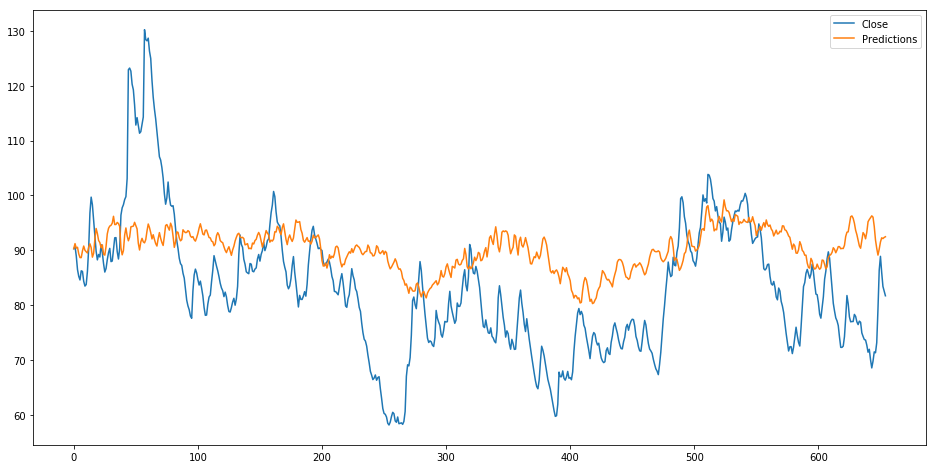

In [39]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 反归一化
closing_price_original = (closing_price.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
y_valid_original = (y_valid.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
# 创建图表
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price_original.flatten(),
    'Close': y_valid_original.flatten()
}
data_pd = pd.DataFrame(dict_data)
plt.plot(data_pd[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper right')
plt.show()
# 保存预测值
pd.DataFrame(closing_price_original).to_csv('data/NBERTS_pred_TJ.csv', index=False)

In [40]:
# valid.iloc[time_stamp:,0].values == y_valid

train_labels = list(data.iloc[:split,0])   # data.iloc[split:,0]
test_labels = list(data.iloc[:,0])

prediction_values = closing_price.reshape(1,-1)[0]
prediction_exp = prediction_values * (max_value[0] - min_value[0]) + min_value[0]
prediction_list = list(prediction_exp)
all_labels = train_labels + prediction_list

labels_dict = {'prediction': all_labels, 'test': test_labels}
df_labels = pd.DataFrame(labels_dict)

In [41]:
df_labels

,prediction,test
0,310.000000,310
1,225.000000,225
2,275.000000,275
3,126.000000,126
4,116.000000,116
5,295.000000,295
6,248.000000,248
7,42.000000,42
8,109.000000,109
9,70.000000,70


In [42]:
def exp_reversed(df, alpha):
    row_0 = df.iloc[0]
    df_t_1 = df.iloc[:0].append(row_0, ignore_index=True).append(df.iloc[:-1], ignore_index=True)
    results = (df - (1-alpha)*df_t_1)/alpha
    results.iloc[0] = df.iloc[0]
    return results
    
original_labels = exp_reversed(df_labels, alpha)
original_labels

,prediction,test
0,310.000000,310.0
1,-1390.000000,-1390.0
2,1225.000000,1225.0
3,-2705.000000,-2705.0
4,-74.000000,-74.0
5,3696.000000,3696.0
6,-645.000000,-645.0
7,-3872.000000,-3872.0
8,1382.000000,1382.0
9,-671.000000,-671.0
